In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 18.5 MB/s eta 0:00:00


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00


In [3]:
!pip install torch

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import RobertaTokenizer, RobertaModel
import torch_geometric.utils as utils

In [8]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available.")

Using device: cuda
CUDA is available!
Device count: 1
Current device: 0
Device name: Tesla T4


In [9]:
# Load the dataset
file_path = 'zinc.csv'  # Adjust to your file path
df = pd.read_csv(file_path)
# Use a subset of 10,000 samples
df = df.sample(n=50000, random_state=42).reset_index(drop=True)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  50000 non-null  object 
 1   logP    50000 non-null  float64
 2   qed     50000 non-null  float64
 3   SAS     50000 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


In [11]:
df.describe()

,logP,qed,SAS
count,50000.000000,50000.000000,50000.000000
mean,2.458761,0.728960,3.047878
std,1.430576,0.139283,0.836226
min,-6.032800,0.111811,1.301357
25%,1.585300,0.646571,2.413281
50%,2.610850,0.760996,2.883534
75%,3.484585,0.836193,3.533836
max,7.994220,0.947685,6.965023


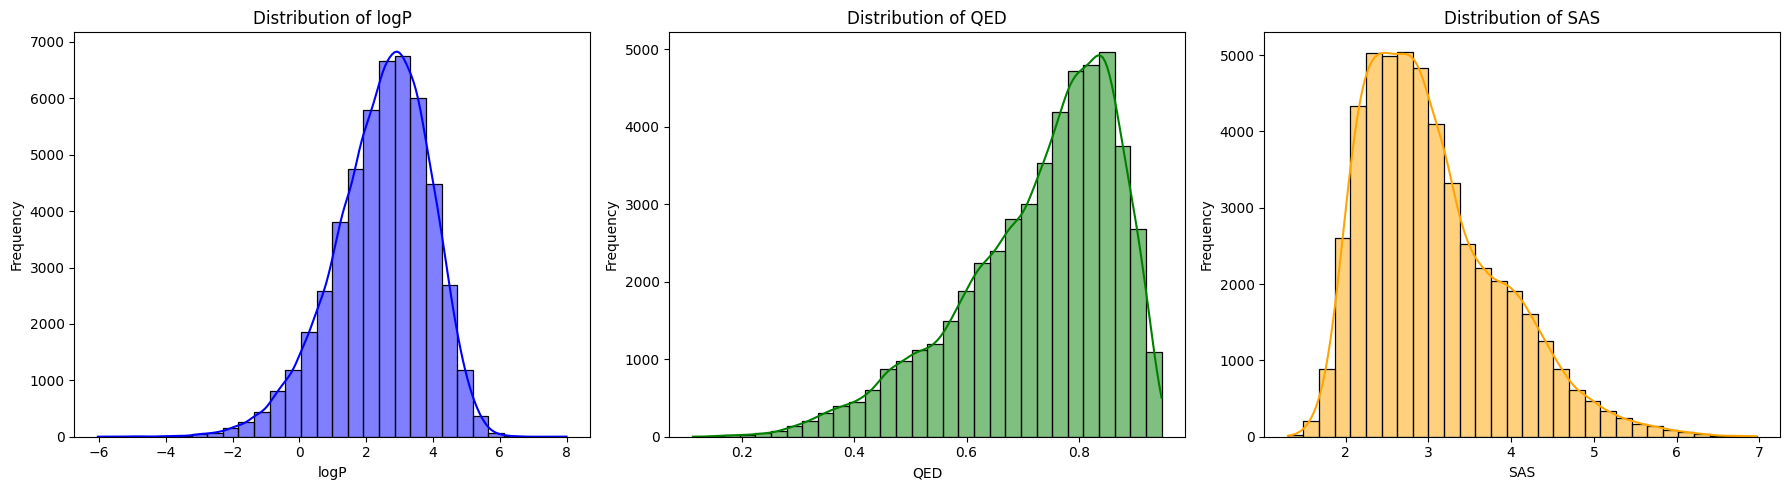

In [12]:
# Assuming df is your DataFrame that contains logP, qed, and sas columns
plt.figure(figsize=(18, 5))

# logP distribution
plt.subplot(1, 3, 1)
sns.histplot(df['logP'], bins=30, kde=True, color='blue')
plt.title('Distribution of logP')
plt.xlabel('logP')
plt.ylabel('Frequency')

# QED distribution
plt.subplot(1, 3, 2)
sns.histplot(df['qed'], bins=30, kde=True, color='green')
plt.title('Distribution of QED')
plt.xlabel('QED')
plt.ylabel('Frequency')

# SAS distribution
plt.subplot(1, 3, 3)
sns.histplot(df['SAS'], bins=30, kde=True, color='orange')
plt.title('Distribution of SAS')
plt.xlabel('SAS')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [13]:
# Check missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

# Drop rows with missing values
df = df.dropna()



Missing values:
 Series([], dtype: int64)


In [14]:
# Load ChemBERTa tokenizer and model using RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('seyonec/ChemBERTa-zinc-base-v1')
chemberta_model = RobertaModel.from_pretrained('seyonec/ChemBERTa-zinc-base-v1').to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [15]:
# Function to generate embeddings using ChemBERTa
def generate_chemberta_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = chemberta_model(**inputs)
    # Return the last hidden state (mean pooling)
    return outputs.last_hidden_state.mean(dim=1)


In [16]:
# Create datasets for (logP, QED) and SAS
logp_qed_data = []
sas_data = []

In [17]:
# Use tqdm to show progress while generating embeddings
for index, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Generating embeddings"):
    smiles = row['smiles']  # Assuming your DataFrame has a 'SMILES' column
    logp, qed, sas = row[['logP', 'qed', 'SAS']]

    # Generate embeddings for the SMILES representation
    embedding = generate_chemberta_embedding(smiles)

    # Create a complex graph structure with edges
    edge_index = utils.dense_to_sparse(torch.ones((1, 1), device=device))[0]  # Dummy edge for demonstration
    logp_qed_graph = Data(x=embedding.unsqueeze(0), edge_index=edge_index,
                           y=torch.tensor([logp, qed], dtype=torch.float).view(1, 2).to(device))
    sas_graph = Data(x=embedding.unsqueeze(0), edge_index=edge_index,
                     y=torch.tensor([sas], dtype=torch.float).view(1, 1).to(device))

    logp_qed_data.append(logp_qed_graph)
    sas_data.append(sas_graph)

Generating embeddings: 100%|██████████| 50000/50000 [07:46<00:00, 107.23it/s]


In [18]:
# Split data into train and test sets
logp_qed_train, logp_qed_test = train_test_split(logp_qed_data, test_size=0.2, random_state=42)
sas_train, sas_test = train_test_split(sas_data, test_size=0.2, random_state=42)


In [19]:
# Create DataLoaders
logp_qed_train_loader = DataLoader(logp_qed_train, batch_size=32, shuffle=True)
logp_qed_test_loader = DataLoader(logp_qed_test, batch_size=32, shuffle=False)
sas_train_loader = DataLoader(sas_train, batch_size=32, shuffle=True)
sas_test_loader = DataLoader(sas_test, batch_size=32, shuffle=False)


In [20]:
# Define the MPNN class with dropout
class MPNN(MessagePassing):
    def __init__(self, hidden_dim, output_dim, dropout_rate=0.2):
        super(MPNN, self).__init__(aggr='mean')  # Use mean aggregation
        self.fc1 = torch.nn.Linear(768, hidden_dim)
        self.dropout = torch.nn.Dropout(dropout_rate)  # Dropout layer
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # Start message passing
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        return self.fc2(x)

    def message(self, x_j):
        return x_j  # Identity function for messages


In [21]:
# Learning rate scheduler
def get_lr_scheduler(optimizer):
    return optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)


In [22]:

# Initialize and train the model for logP/QED
logp_qed_model = MPNN(hidden_dim=128, output_dim=2).to(device)  # Increased hidden dimension
logp_qed_optimizer = optim.Adam(logp_qed_model.parameters(), lr=0.001)
logp_qed_scheduler = get_lr_scheduler(logp_qed_optimizer)


In [23]:
# Early stopping parameters
early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0


In [24]:
# Training loop for logP/QED
epochs = 20
logp_qed_metrics_list = []

for epoch in range(epochs):
    logp_qed_model.train()
    epoch_loss = 0
    with tqdm(total=len(logp_qed_train_loader), desc=f'Training LogP/QED Epoch {epoch+1}/{epochs}') as pbar:
        for batch in logp_qed_train_loader:
            batch = batch.to(device)
            logp_qed_optimizer.zero_grad()
            output = logp_qed_model(batch.x, batch.edge_index)
            loss = F.mse_loss(output, batch.y)
            loss.backward()
            logp_qed_optimizer.step()
            epoch_loss += loss.item()
            pbar.update(1)

    # Calculate metrics after each epoch
    logp_qed_model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for batch in logp_qed_test_loader:
            batch = batch.to(device)
            output = logp_qed_model(batch.x, batch.edge_index)
            y_true.append(batch.y.cpu().numpy())
            y_pred.append(output.cpu().numpy())

        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        # Print shapes for debugging
        print("y_true shape:", y_true.shape)
        print("y_pred shape:", y_pred.shape)

        # Reshape y_pred to match y_true
        if y_pred.ndim == 3 and y_pred.shape[1] == 1:
            y_pred = y_pred.reshape(y_pred.shape[0], -1)

        # Print the reshaped dimensions
        print("Reshaped y_pred shape:", y_pred.shape)

        # Calculate metrics
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE
        mse = mean_squared_error(y_true, y_pred)  # MSE

        # Display metrics
        print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}, MAPE: {mape}, MSE: {mse}")

    logp_qed_metrics_list.append({'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape, 'mse': mse})
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(logp_qed_train_loader):.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}, MSE: {mse:.4f}')

    # Scheduler step
    logp_qed_scheduler.step(rmse)

    # Early stopping
    if rmse < best_loss:
        best_loss = rmse
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break


Training LogP/QED Epoch 1/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 1/20: 100%|██████████| 1250/1250 [00:10<00:00, 121.00it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7920759916305542, MAE: 0.6316086053848267, R2: -0.41818851232528687, MAPE: 117.50949621200562, MSE: 0.9893001317977905
Epoch 1/20, Loss: 1.0928, RMSE: 0.7921, MAE: 0.6316, R2: -0.4182, MAPE: 117.5095, MSE: 0.9893


Training LogP/QED Epoch 2/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 2/20: 100%|██████████| 1250/1250 [00:09<00:00, 128.10it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7837190628051758, MAE: 0.608920693397522, R2: -0.02209395170211792, MAPE: 125.5272626876831, MSE: 1.026746392250061
Epoch 2/20, Loss: 1.0749, RMSE: 0.7837, MAE: 0.6089, R2: -0.0221, MAPE: 125.5273, MSE: 1.0267


Training LogP/QED Epoch 3/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 3/20: 100%|██████████| 1250/1250 [00:09<00:00, 132.13it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7673067450523376, MAE: 0.606688380241394, R2: -0.0024404823780059814, MAPE: 111.78597211837769, MSE: 0.9798247814178467
Epoch 3/20, Loss: 1.0730, RMSE: 0.7673, MAE: 0.6067, R2: -0.0024, MAPE: 111.7860, MSE: 0.9798


Training LogP/QED Epoch 4/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 4/20: 100%|██████████| 1250/1250 [00:09<00:00, 135.27it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7672662138938904, MAE: 0.6056585907936096, R2: 0.0016356110572814941, MAPE: 115.94511270523071, MSE: 0.9804746508598328
Epoch 4/20, Loss: 1.0742, RMSE: 0.7673, MAE: 0.6057, R2: 0.0016, MAPE: 115.9451, MSE: 0.9805


Training LogP/QED Epoch 5/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 5/20: 100%|██████████| 1250/1250 [00:08<00:00, 141.62it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7741823792457581, MAE: 0.6240585446357727, R2: -0.004879683256149292, MAPE: 103.6299467086792, MSE: 1.000449538230896
Epoch 5/20, Loss: 1.0689, RMSE: 0.7742, MAE: 0.6241, R2: -0.0049, MAPE: 103.6299, MSE: 1.0004


Training LogP/QED Epoch 6/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 6/20: 100%|██████████| 1250/1250 [00:08<00:00, 146.47it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7673647999763489, MAE: 0.6102426052093506, R2: -0.013423770666122437, MAPE: 112.64138221740723, MSE: 0.9779388904571533
Epoch 6/20, Loss: 1.0664, RMSE: 0.7674, MAE: 0.6102, R2: -0.0134, MAPE: 112.6414, MSE: 0.9779


Training LogP/QED Epoch 7/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 7/20: 100%|██████████| 1250/1250 [00:09<00:00, 134.51it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7741072773933411, MAE: 0.608363926410675, R2: -0.059580206871032715, MAPE: 114.2706036567688, MSE: 0.9900309443473816
Epoch 7/20, Loss: 1.0674, RMSE: 0.7741, MAE: 0.6084, R2: -0.0596, MAPE: 114.2706, MSE: 0.9900


Training LogP/QED Epoch 8/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 8/20: 100%|██████████| 1250/1250 [00:09<00:00, 129.63it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7599043846130371, MAE: 0.6062100529670715, R2: 0.0026528239250183105, MAPE: 109.7796082496643, MSE: 0.95835942029953
Epoch 8/20, Loss: 1.0618, RMSE: 0.7599, MAE: 0.6062, R2: 0.0027, MAPE: 109.7796, MSE: 0.9584


Training LogP/QED Epoch 9/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 9/20: 100%|██████████| 1250/1250 [00:09<00:00, 135.11it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7642123699188232, MAE: 0.6032307147979736, R2: 0.017117679119110107, MAPE: 113.42076063156128, MSE: 0.9741301536560059
Epoch 9/20, Loss: 1.0629, RMSE: 0.7642, MAE: 0.6032, R2: 0.0171, MAPE: 113.4208, MSE: 0.9741


Training LogP/QED Epoch 10/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 10/20: 100%|██████████| 1250/1250 [00:09<00:00, 138.82it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7608487606048584, MAE: 0.600828230381012, R2: 0.018213868141174316, MAPE: 112.57357597351074, MSE: 0.9641317129135132
Epoch 10/20, Loss: 1.0589, RMSE: 0.7608, MAE: 0.6008, R2: 0.0182, MAPE: 112.5736, MSE: 0.9641


Training LogP/QED Epoch 11/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 11/20: 100%|██████████| 1250/1250 [00:08<00:00, 146.49it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.769078254699707, MAE: 0.601665735244751, R2: 0.005839139223098755, MAPE: 120.03943920135498, MSE: 0.9868207573890686
Epoch 11/20, Loss: 1.0604, RMSE: 0.7691, MAE: 0.6017, R2: 0.0058, MAPE: 120.0394, MSE: 0.9868


Training LogP/QED Epoch 12/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 12/20: 100%|██████████| 1250/1250 [00:07<00:00, 157.19it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7641597986221313, MAE: 0.6059573888778687, R2: 0.018237531185150146, MAPE: 111.55017614364624, MSE: 0.9741857647895813
Epoch 12/20, Loss: 1.0597, RMSE: 0.7642, MAE: 0.6060, R2: 0.0182, MAPE: 111.5502, MSE: 0.9742


Training LogP/QED Epoch 13/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 13/20: 100%|██████████| 1250/1250 [00:06<00:00, 198.58it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7690554261207581, MAE: 0.5999265909194946, R2: 0.011249154806137085, MAPE: 120.48525810241699, MSE: 0.9877977967262268
Epoch 13/20, Loss: 1.0565, RMSE: 0.7691, MAE: 0.5999, R2: 0.0112, MAPE: 120.4853, MSE: 0.9878


Training LogP/QED Epoch 14/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 14/20: 100%|██████████| 1250/1250 [00:05<00:00, 222.00it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7719047665596008, MAE: 0.6185654401779175, R2: 0.004166513681411743, MAPE: 105.78429698944092, MSE: 0.9951810836791992
Epoch 14/20, Loss: 1.0549, RMSE: 0.7719, MAE: 0.6186, R2: 0.0042, MAPE: 105.7843, MSE: 0.9952


Training LogP/QED Epoch 15/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 15/20: 100%|██████████| 1250/1250 [00:06<00:00, 184.47it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7661523222923279, MAE: 0.5996904373168945, R2: 0.01100844144821167, MAPE: 117.36091375350952, MSE: 0.9788682460784912
Epoch 15/20, Loss: 1.0495, RMSE: 0.7662, MAE: 0.5997, R2: 0.0110, MAPE: 117.3609, MSE: 0.9789


Training LogP/QED Epoch 16/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 16/20: 100%|██████████| 1250/1250 [00:07<00:00, 163.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.764000415802002, MAE: 0.6088569760322571, R2: 0.016889959573745728, MAPE: 109.18009281158447, MSE: 0.9734413027763367
Epoch 16/20, Loss: 1.0494, RMSE: 0.7640, MAE: 0.6089, R2: 0.0169, MAPE: 109.1801, MSE: 0.9734


Training LogP/QED Epoch 17/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 17/20: 100%|██████████| 1250/1250 [00:05<00:00, 217.16it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7677992582321167, MAE: 0.5995091199874878, R2: -0.011721372604370117, MAPE: 117.50150918960571, MSE: 0.9795787334442139
Epoch 17/20, Loss: 1.0504, RMSE: 0.7678, MAE: 0.5995, R2: -0.0117, MAPE: 117.5015, MSE: 0.9796


Training LogP/QED Epoch 18/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-24-90817d2976f9>:13: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training LogP/QED Epoch 18/20: 100%|██████████| 1250/1250 [00:09<00:00, 130.72it/s]


y_true shape: (10000, 2)
y_pred shape: (10000, 1, 2)
Reshaped y_pred shape: (10000, 2)
RMSE: 0.7621473073959351, MAE: 0.605488121509552, R2: 0.021247923374176025, MAPE: 110.69583892822266, MSE: 0.9686469435691833
Epoch 18/20, Loss: 1.0494, RMSE: 0.7621, MAE: 0.6055, R2: 0.0212, MAPE: 110.6958, MSE: 0.9686
Early stopping triggered.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
# Initialize and train the model for SAS
sas_model = MPNN(hidden_dim=128, output_dim=1).to(device)  # Increased hidden dimension
sas_optimizer = optim.Adam(sas_model.parameters(), lr=0.001)
sas_scheduler = get_lr_scheduler(sas_optimizer)


In [27]:
# Early stopping parameters for SAS
early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0


In [28]:
# SAS model training loop with MAPE, MSE, and MAE
sas_metrics_list = []

for epoch in range(epochs):
    sas_model.train()
    epoch_loss = 0
    with tqdm(total=len(sas_train_loader), desc=f'Training SAS Epoch {epoch+1}/{epochs}') as pbar:
        for batch in sas_train_loader:
            batch = batch.to(device)
            sas_optimizer.zero_grad()
            output = sas_model(batch.x, batch.edge_index)
            loss = F.mse_loss(output, batch.y)
            loss.backward()
            sas_optimizer.step()
            epoch_loss += loss.item()
            pbar.update(1)

    # Calculate metrics after each epoch
    sas_model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for batch in sas_test_loader:
            batch = batch.to(device)
            output = sas_model(batch.x, batch.edge_index)
            y_true.append(batch.y.cpu().numpy())
            y_pred.append(output.cpu().numpy())

        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        # Print shapes for debugging
        print("y_true shape:", y_true.shape)
        print("y_pred shape:", y_pred.shape)

        # Reshape y_pred to match y_true
        if y_pred.ndim == 3 and y_pred.shape[1] == 1:
            y_pred = y_pred.reshape(y_pred.shape[0], -1)

        # Print the reshaped dimensions
        print("Reshaped y_pred shape:", y_pred.shape)

        # Calculate metrics
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE
        mse = mean_squared_error(y_true, y_pred)  # MSE

        # Display metrics
        print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}, MAPE: {mape}, MSE: {mse}")

    sas_metrics_list.append({'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape, 'mse': mse})
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(sas_train_loader):.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}, MSE: {mse:.4f}')

    # Scheduler step
    sas_scheduler.step(rmse)

    # Early stopping
    if rmse < best_loss:
        best_loss = rmse
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break


Training SAS Epoch 1/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 1/20: 100%|██████████| 1250/1250 [00:13<00:00, 92.93it/s] 
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8796179294586182, MAE: 0.6510444283485413, R2: -0.09565174579620361, MAPE: 20.019403100013733, MSE: 0.7737276554107666
Epoch 1/20, Loss: 0.7883, RMSE: 0.8796, MAE: 0.6510, R2: -0.0957, MAPE: 20.0194, MSE: 0.7737


Training SAS Epoch 2/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 2/20: 100%|██████████| 1250/1250 [00:09<00:00, 131.95it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8352382779121399, MAE: 0.6489241719245911, R2: 0.01211768388748169, MAPE: 21.481509506702423, MSE: 0.6976229548454285
Epoch 2/20, Loss: 0.7622, RMSE: 0.8352, MAE: 0.6489, R2: 0.0121, MAPE: 21.4815, MSE: 0.6976


Training SAS Epoch 3/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 3/20: 100%|██████████| 1250/1250 [00:08<00:00, 142.03it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8183008432388306, MAE: 0.6408436298370361, R2: 0.051777184009552, MAPE: 21.440942585468292, MSE: 0.6696162223815918
Epoch 3/20, Loss: 0.7532, RMSE: 0.8183, MAE: 0.6408, R2: 0.0518, MAPE: 21.4409, MSE: 0.6696


Training SAS Epoch 4/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 4/20: 100%|██████████| 1250/1250 [00:08<00:00, 148.45it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8636699318885803, MAE: 0.6410982608795166, R2: -0.0562824010848999, MAPE: 19.816511869430542, MSE: 0.7459257245063782
Epoch 4/20, Loss: 0.7520, RMSE: 0.8637, MAE: 0.6411, R2: -0.0563, MAPE: 19.8165, MSE: 0.7459


Training SAS Epoch 5/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 5/20: 100%|██████████| 1250/1250 [00:09<00:00, 137.51it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8284159898757935, MAE: 0.6900188326835632, R2: 0.02818995714187622, MAPE: 24.894580245018005, MSE: 0.6862730383872986
Epoch 5/20, Loss: 0.7481, RMSE: 0.8284, MAE: 0.6900, R2: 0.0282, MAPE: 24.8946, MSE: 0.6863


Training SAS Epoch 6/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 6/20: 100%|██████████| 1250/1250 [00:09<00:00, 135.36it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8157667517662048, MAE: 0.6322977542877197, R2: 0.057640910148620605, MAPE: 20.904509723186493, MSE: 0.6654753684997559
Epoch 6/20, Loss: 0.7457, RMSE: 0.8158, MAE: 0.6323, R2: 0.0576, MAPE: 20.9045, MSE: 0.6655


Training SAS Epoch 7/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 7/20: 100%|██████████| 1250/1250 [00:09<00:00, 135.40it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8328971266746521, MAE: 0.686205267906189, R2: 0.017647981643676758, MAPE: 24.454721808433533, MSE: 0.6937175989151001
Epoch 7/20, Loss: 0.7414, RMSE: 0.8329, MAE: 0.6862, R2: 0.0176, MAPE: 24.4547, MSE: 0.6937


Training SAS Epoch 8/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 8/20: 100%|██████████| 1250/1250 [00:08<00:00, 143.94it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8107811808586121, MAE: 0.6341797113418579, R2: 0.06912410259246826, MAPE: 21.169213950634003, MSE: 0.657366156578064
Epoch 8/20, Loss: 0.7422, RMSE: 0.8108, MAE: 0.6342, R2: 0.0691, MAPE: 21.1692, MSE: 0.6574


Training SAS Epoch 9/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 9/20: 100%|██████████| 1250/1250 [00:05<00:00, 215.48it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8379050493240356, MAE: 0.6316484212875366, R2: 0.005799412727355957, MAPE: 20.09264826774597, MSE: 0.7020848393440247
Epoch 9/20, Loss: 0.7407, RMSE: 0.8379, MAE: 0.6316, R2: 0.0058, MAPE: 20.0926, MSE: 0.7021


Training SAS Epoch 10/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 10/20: 100%|██████████| 1250/1250 [00:07<00:00, 172.63it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.840155839920044, MAE: 0.6364702582359314, R2: 0.0004507899284362793, MAPE: 20.365454256534576, MSE: 0.7058618664741516
Epoch 10/20, Loss: 0.7354, RMSE: 0.8402, MAE: 0.6365, R2: 0.0005, MAPE: 20.3655, MSE: 0.7059


Training SAS Epoch 11/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 11/20: 100%|██████████| 1250/1250 [00:09<00:00, 133.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8482227325439453, MAE: 0.6308537125587463, R2: -0.018835902214050293, MAPE: 19.577880203723907, MSE: 0.7194817662239075
Epoch 11/20, Loss: 0.7328, RMSE: 0.8482, MAE: 0.6309, R2: -0.0188, MAPE: 19.5779, MSE: 0.7195


Training SAS Epoch 12/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 12/20: 100%|██████████| 1250/1250 [00:08<00:00, 145.03it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.834312915802002, MAE: 0.6388817429542542, R2: 0.014305353164672852, MAPE: 20.7364484667778, MSE: 0.6960780620574951
Epoch 12/20, Loss: 0.7331, RMSE: 0.8343, MAE: 0.6389, R2: 0.0143, MAPE: 20.7364, MSE: 0.6961


Training SAS Epoch 13/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 13/20: 100%|██████████| 1250/1250 [00:09<00:00, 133.42it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8165068626403809, MAE: 0.6384658217430115, R2: 0.05593007802963257, MAPE: 21.31464183330536, MSE: 0.6666834950447083
Epoch 13/20, Loss: 0.7297, RMSE: 0.8165, MAE: 0.6385, R2: 0.0559, MAPE: 21.3146, MSE: 0.6667


Training SAS Epoch 14/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 14/20: 100%|██████████| 1250/1250 [00:09<00:00, 131.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8202170729637146, MAE: 0.6247752904891968, R2: 0.04733085632324219, MAPE: 20.16509473323822, MSE: 0.6727560758590698
Epoch 14/20, Loss: 0.7278, RMSE: 0.8202, MAE: 0.6248, R2: 0.0473, MAPE: 20.1651, MSE: 0.6728


Training SAS Epoch 15/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 15/20: 100%|██████████| 1250/1250 [00:09<00:00, 131.52it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8189631104469299, MAE: 0.6452876329421997, R2: 0.05024164915084839, MAPE: 21.755388379096985, MSE: 0.6707006096839905
Epoch 15/20, Loss: 0.7173, RMSE: 0.8190, MAE: 0.6453, R2: 0.0502, MAPE: 21.7554, MSE: 0.6707


Training SAS Epoch 16/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 16/20: 100%|██████████| 1250/1250 [00:09<00:00, 135.15it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8206432461738586, MAE: 0.6478110551834106, R2: 0.04634064435958862, MAPE: 21.900756657123566, MSE: 0.6734553575515747
Epoch 16/20, Loss: 0.7190, RMSE: 0.8206, MAE: 0.6478, R2: 0.0463, MAPE: 21.9008, MSE: 0.6735


Training SAS Epoch 17/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 17/20: 100%|██████████| 1250/1250 [00:08<00:00, 150.67it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8279236555099487, MAE: 0.66098952293396, R2: 0.02934473752975464, MAPE: 22.62808531522751, MSE: 0.6854575872421265
Epoch 17/20, Loss: 0.7182, RMSE: 0.8279, MAE: 0.6610, R2: 0.0293, MAPE: 22.6281, MSE: 0.6855


Training SAS Epoch 18/20:   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-28-a3e772818bd3>:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y)
Training SAS Epoch 18/20: 100%|██████████| 1250/1250 [00:09<00:00, 136.24it/s]


y_true shape: (10000, 1)
y_pred shape: (10000, 1, 1)
Reshaped y_pred shape: (10000, 1)
RMSE: 0.8237398862838745, MAE: 0.6488530039787292, R2: 0.03913003206253052, MAPE: 21.860788762569427, MSE: 0.6785473823547363
Epoch 18/20, Loss: 0.7168, RMSE: 0.8237, MAE: 0.6489, R2: 0.0391, MAPE: 21.8608, MSE: 0.6785
Early stopping triggered.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


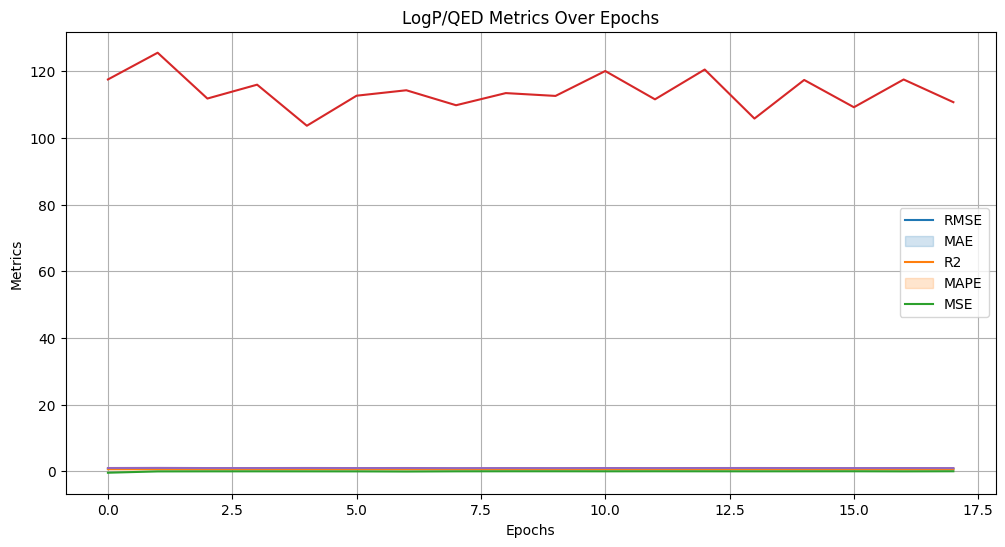

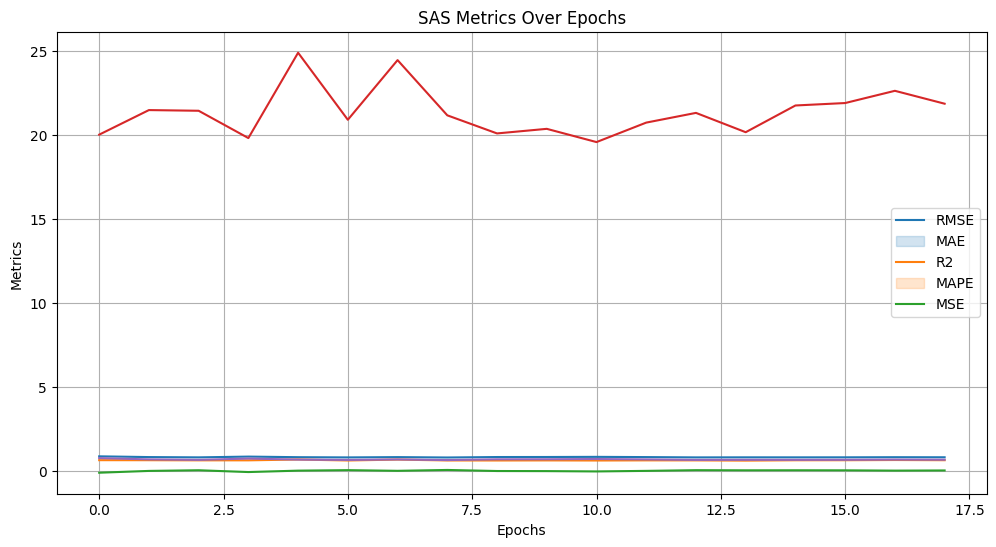

In [29]:
# Visualization of the results
logp_qed_metrics_df = pd.DataFrame(logp_qed_metrics_list)
sas_metrics_df = pd.DataFrame(sas_metrics_list)

plt.figure(figsize=(12, 6))
sns.lineplot(data=logp_qed_metrics_df[['rmse', 'mae', 'r2', 'mape', 'mse']], dashes=False)
plt.title('LogP/QED Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['RMSE', 'MAE', 'R2', 'MAPE', 'MSE'])
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=sas_metrics_df[['rmse', 'mae', 'r2', 'mape', 'mse']], dashes=False)
plt.title('SAS Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['RMSE', 'MAE', 'R2', 'MAPE', 'MSE'])
plt.grid()
plt.show()


In [30]:
# Tabulating results
logp_qed_results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R2', 'MAPE', 'MSE'],
    'Final LogP/QED Values': [logp_qed_metrics_df['rmse'].iloc[-1],
                               logp_qed_metrics_df['mae'].iloc[-1],
                               logp_qed_metrics_df['r2'].iloc[-1],
                               logp_qed_metrics_df['mape'].iloc[-1],
                               logp_qed_metrics_df['mse'].iloc[-1]]
})

sas_results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R2', 'MAPE', 'MSE'],
    'Final SAS Values': [sas_metrics_df['rmse'].iloc[-1],
                         sas_metrics_df['mae'].iloc[-1],
                         sas_metrics_df['r2'].iloc[-1],
                         sas_metrics_df['mape'].iloc[-1],
                         sas_metrics_df['mse'].iloc[-1]]
})

print("LogP/QED Results:")
print(logp_qed_results)

print("\nSAS Results:")
print(sas_results)

LogP/QED Results:
  Metric  Final LogP/QED Values
0   RMSE               0.762147
1    MAE               0.605488
2     R2               0.021248
3   MAPE             110.695839
4    MSE               0.968647

SAS Results:
  Metric  Final SAS Values
0   RMSE          0.823740
1    MAE          0.648853
2     R2          0.039130
3   MAPE         21.860789
4    MSE          0.678547
